# **Lezione 7**

### **Esercizio 7.1**
Nel calcolo dell'energia potenziale e della pressione implementato in NSL_SIMULATOR è stato scelto un ragio di cut-off, per troncare i contributi delle particelle che si trovano a una distanza maggiore di questo raggio. Per tenere conto anche di queste interazioni "di coda", dobbiamo introdurre delle correzioni:
$$
\frac{\langle U \rangle_{tail}}{N}=\pi \rho \epsilon \Biggl[\frac{1}{9r_c^9} - \frac{1}{3r_c^3}\Biggr]     \hspace{1cm}    
\frac{\langle W \rangle_{tail}}{3N\epsilon}=32 \pi \rho \Biggl[\frac{1}{9r_c^9} - \frac{1}{6r_c^3}\Biggr]
$$
dove $r_c, \rho$ sono espressi in unità ridotte e l'unità di energia è $\epsilon=1.$ Le correzioni sono state implementate in system.cpp in questo modo:
```cpp
    if( property == "POTENTIAL_ENERGY" ){
        ...
        __vtail = 8*M_PI*_rho/(9*pow(_r_cut,9)) - 8*M_PI*_rho/(3*pow(_r_cut,3));
    } else if( property == "PRESSURE" ){
        ...
        _ptail = 32*M_PI*_rho*(1/(9*pow(_r_cut,9))-1/(6*pow(_r_cut,3)));
    }
```
e ogni volta che il potenziale o la pressione sono calcolati nel codice, queste correzioni di coda vengono aggiunte al risultato finale.

### **Esercizio 7.2**

L’obiettivo dell’esercizio è quello di analizzare l’andamento dell’energia potenziale per particella $U/N$ durante simulazioni Monte Carlo (MC) in ensemble 
$NVT$ e simulazioni di Dinamica Molecolare (MD) in ensemble $NVE$, eseguite tramite il codice `NSL_SIMULATOR`.   

Le simulazioni sono svolte in condizioni termodinamiche corrispondenti alla fase liquida, ovvero a densità ridotta $\rho^* =0.8$, temperatura ridotta $T^* =1.1$, e raggio di cut-off $r_c^* =2.5$. Nel caso MD, è stato utilizzato un passo temporale $ dt =0.001$.

Una volta equilibrato il sistema, si sono svolte simulazioni di lunghezza $M=5 \times10^5$ passi, durante le quali è stato registrato ad ogni passo il valore istantaneo dell’energia potenziale per particella $U/N$ e la sua incertezza statistica. 

I dati ottenuti sono stati poi analizzati per calcolare la funzione di autocorrelazione dei dati di $U/N$, al fine di stimare quanto passi sono necessari per far si che due misure consecutive siano statisticamente indipendenti. Questa stima è essenziale per la corretta scelta della dimensione dei blocchi nella tecnica di data blocking.

Seguono dunque i grafici

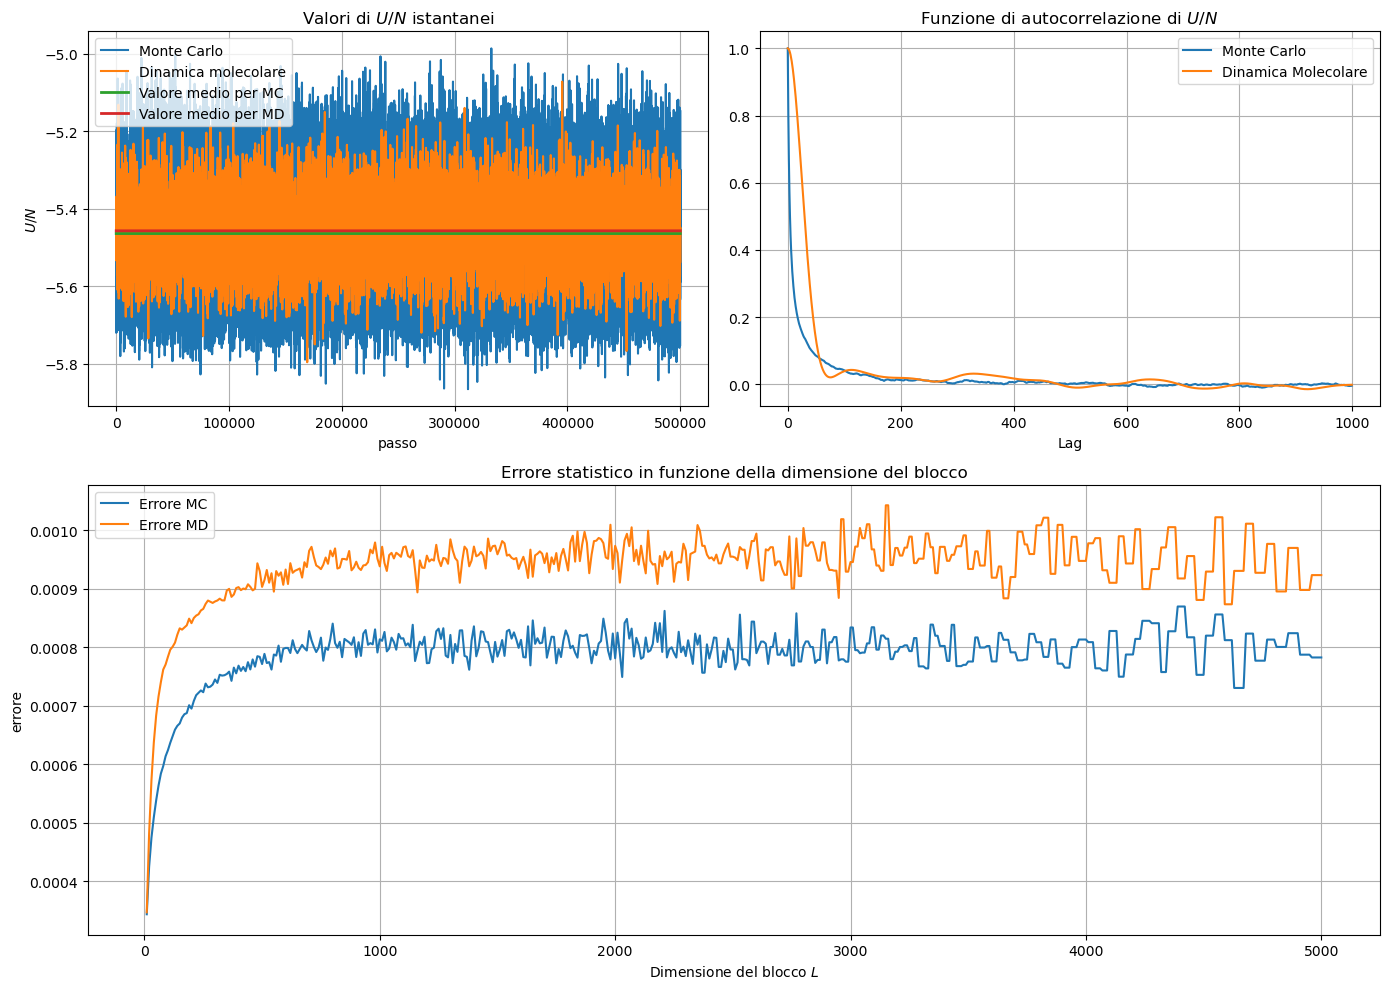

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Caricamento dati
t, U_MC = np.loadtxt("FILES_7.2/MC_potential_energy.dat", usecols=(0, 1), unpack=True)
U_MD = np.loadtxt("FILES_7.2/MD_potential_energy.dat", usecols=(1), unpack=True)

# Calcolo autocorrelazione
def autocorrelation_fft(x):
    x = x - np.mean(x)
    N = len(x)
    fft_x = np.fft.fft(x, n=2*N)
    S = np.real(np.fft.ifft(fft_x * np.conjugate(fft_x)))[:N]
    norm = (N - np.arange(N)) * np.var(x)
    return S / norm

max_lag = 1000
autocorr_MC = autocorrelation_fft(U_MC)
autocorr_MD = autocorrelation_fft(U_MD)
t_vals = np.arange(max_lag)

# Calcolo errori con data blocking
def block_average(data, n_blocks):
    N = len(data)
    if N % n_blocks != 0:
        data = data[:N - (N % n_blocks)]
    block_size = len(data) // n_blocks
    blocks = data.reshape((n_blocks, block_size))
    means = blocks.mean(axis=1)
    mean_of_means = means.mean()
    std_error = np.sqrt(np.var(means, ddof=1) / n_blocks)
    return mean_of_means, std_error

min_L = 10
max_L = 5000
step_L = 10
block_sizes = np.arange(min_L, max_L + 1, step_L)

errors_md = []
errors_mc = []
valid_block_sizes_md = []
valid_block_sizes_mc = []

M_md = len(U_MD)
M_mc = len(U_MC)

for L in block_sizes:
    if M_md // L < 2:
        continue
    n_blocks = M_md // L
    _, err = block_average(U_MD, n_blocks)
    errors_md.append(err)
    valid_block_sizes_md.append(L)

for L in block_sizes:
    if M_mc // L < 2:
        continue
    n_blocks = M_mc // L
    _, err = block_average(U_MC, n_blocks)
    errors_mc.append(err)
    valid_block_sizes_mc.append(L)

# Creazione layout: 2 sopra (1x2) e 1 sotto (2 colonne unite)
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])  # più spazio per quello sotto

# Primo plot: energia
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(U_MC, label="Monte Carlo")
ax0.plot(U_MD, label="Dinamica molecolare")
mean_MC = np.mean(U_MC)
vec_MC=np.full_like(U_MC,mean_MC)
ax0.plot(vec_MC, label="Valore medio per MC", zorder=3, linewidth=2)
mean_MD = np.mean(U_MD)
vec_MD=np.full_like(U_MD,mean_MD)
ax0.plot(vec_MD, label="Valore medio per MD",zorder=4, linewidth=2)
ax0.set_ylabel('$U/N$')
ax0.set_xlabel('passo')
ax0.legend(loc='upper left')
ax0.grid(True)
ax0.set_title('Valori di $U/N$ istantanei')

# Secondo plot: autocorrelazione
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(t_vals, autocorr_MC[:max_lag], label='Monte Carlo')
ax1.plot(t_vals, autocorr_MD[:max_lag], label='Dinamica Molecolare')
ax1.set_title("Funzione di autocorrelazione di $U/N$")
ax1.set_xlabel("Lag")
ax1.legend(loc='upper right')
ax1.grid(True)

# Terzo plot: errore vs dimensione blocco
ax2 = fig.add_subplot(gs[1, :])  # occupa entrambe le colonne
ax2.plot(valid_block_sizes_mc, errors_mc, label='Errore MC')
ax2.plot(valid_block_sizes_md, errors_md, label='Errore MD')
ax2.set_xlabel("Dimensione del blocco $L$")
ax2.set_ylabel("errore")
ax2.set_title("Errore statistico in funzione della dimensione del blocco")
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()


Nel primo pannello si osserva l'andamento dell'enegia potenziale per particella $U/N$ ottenuta mediante le due simulazioni Monte Carlo (MC) e Dinamica Molecolare (MD). Si osserva:
+ Entrambi i metodi fluttuano intorno a valori medi stabili (tra di loro molto simili), sinonimo del fatto che per entrambi i casi il sistema ha raggiunto l'equilibrio
+ Tuttavia, le fluttuazioni nel caso MC sono molto più grandi, indicando una maggiore varianza. Questo può dipendere dal fatto che MC campiona diverse configurazioni, ma non conserva energia.

Nel secondo pannello è riportata la funzione di autocorrelazione normalizzata dell'energia potenziale sia per MC che per MD. Entrambe le curve mostrano un decadimento rapido nei primi 200 passi. Dopo questo 'lag', le configurazioni diventano statisticamente indipendenti. Da notare inoltre come la curva MC decada più rapidamente di MD, segno che le configurazioni della prima sono meno autocorrelate.

Nell'ultimo grafico viene mostrato come varia l'errore statistico stimato sull'energia potenziale al variare delle dimensioni del blocco L.  All'aumentare di L, l'errore cresce inizialmente per poi stabilizzarsi ad un plateau, che rappresenta una buona stima dell'errore tenendo conto dell'autocorrelazione. Tra i due metodi, MC ha un errore inferiore e raggiunge il plateau più velocemente, stabilizzandosi a $\sim 0.0008$.

È possibile concludere che:
+ MD e MC producono stime coerenti dell’energia media, ma con differente precisione e dinamica.

+ Monte Carlo è più fluttutante ma decorrela più in fretta, con errore statistico più basso.

+ Molecular Dynamics ha fluttuazioni più contenute ma autcorrelazione più lunga. Richiede blocchi più grandi per stimare l’errore correttamente.

+ Per entrambi i metodi una larghezza per i blocchi più che buona è $L=2000$ 


### **Esercizio 7.3**
La richiesta dell'esercizio è quella di implementare all'interno di NSL_SIMULATOR in system.cpp il calcolo della funzione di distribuzione radiale $g(r)$ o GOFR. Questa funzione rappresenta la probabilità normalizzata di trovare una particella alla distanza $r$ da una particella fissata, rispetto al valore atteso per un gas ideale alla stessa densità.

Per un fluido omogeneo la funzione di distribuzione radiale è definita come:
$$
g(r)=\frac{1}{\rho N \Delta V(r)}\Big\langle \sum \sum_{i\not=j=1}^N \delta (r-|\vec{r}_i - \vec{r}_j|) \Big\rangle
$$
dove $\Delta V(r)=\frac{4\pi}{3}[(r+dr)^3-r^3]$ è il volume del guscio sferico di spessore $dr$. 

Vediamo come ho implementato nel codice il calcolo della distribuzione radiale, a cui successivamente è stato applicato il consueto data-blocking:
```cpp
    if (_measure_penergy or _measure_pressure or _measure_gofr) {
      for (int i=0; i<_npart-1; i++){
        for (int j=i+1; j<_npart; j++){
          ...
          if(_measure_gofr){
            int bin_g = int(dr/_bin_size); // -→ dr è la distanza fra le due particelle
            if(bin_g<_n_bins){
              double deltaV = (4./3.)*M_PI*(pow(_bin_size*bin_g + _bin_size,3) - pow(_bin_size*bin_g, 3));
              double norm = _rho*_npart*deltaV;
              _measurement(_index_gofr + bin_g) += 2/norm; // ogni coppia contata una sola volta
            }
          }
        ...
        }
      }
    }
```

### **Esercizio 7.4**

In questo esercizio continuiamo con lo studio un sistema di particelle di Argon interagenti tramite il potenziale di Lennard-Jones, utilizzando il codice NSL_SIMULATOR appena modificato. Lo scopo è confrontare i risultati ottenuti con due approcci numerici differenti: la simulazione Monte Carlo nell’ensemble canonico (NVT) e la Dinamica Molecolare nell’ensemble microcanonico (NVE), operando nelle stesse condizioni termodinamiche.

Il sistema è stato studiato in condizioni di fase liquida, con:
* Densità ridotta: $\rho^\star = 0.8$
* Temperatura ridotta: $T^\star = 1.1$
* Raggio di cut-off: $r_c = 2.5$

Tutte quantità sono fornite al sistema tramite il file di input `input.dat`:
>SIMULATION_TYPE        1    
>RESTART                0    
>TEMP                   1.1     
>NPART                  108    
>RHO                    0.8     
>R_CUT                  2.5      
>DELTA                  0.1     
>NBLOCKS                50    
>NSTEPS                 2000   
>
>ENDINPUT    
>   
>DELTA = 0.1 per MC → sim_type = 1     
>DELTA = 0.001 per MD → sim_type = 0    

Dopo un’adeguata fase di equilibrazione, sono state raccolte misure delle seguenti osservabili termodinamiche:
+ Energia potenziale per particella $U/N$
+ Pressione $P$
+ Funzione di distribuzione radiale $g(r)$

I risultati ottenuti con l’approccio Monte Carlo sono stati confrontati con quelli ottenuti tramite Dinamica Molecolare, al fine di evidenziare analogie e differenze tra i due metodi.

**N.B.** Prima di passare ai risultati preciso che ho fatto una modifica all'interno di  `system.cpp`. Il calcolo della pressione richiede la conoscenza della temperatura, la quale viene dedotta dal valor medio dell'energia cinetica, tramite il principio dell'equipartizione. Tuttavia, mentre in dinamica molecolare le particelle hanno una velocità (e quindi en. cinetica), lo stesso non si può dire per la simulazione Monte Carlo (dove non è definita una dinamica temporale). Dunque l'energia cinetica e la temperatura risultano nulle, impedendo il calcolo della pressione.    
È necessario introdurre un modo artificioso per ottenere l'energia cinetica: prendendo la temperatura passata per input e calcolando l'energia cinetica con l'equipartizione dell'energia. In questo modo poi si recupera correttamente il valore della temperatura iniziale e si può proseguire con il calcolo della pressione, senza modificare significativamente l’architettura del codice o introdurre ulteriori condizioni speciali.

Seguono dunque i grafici che comparano le due simulazioni: in arancio i risultati della dinamica molecolare, in azzurro quelli della simulazione Monte Carlo.

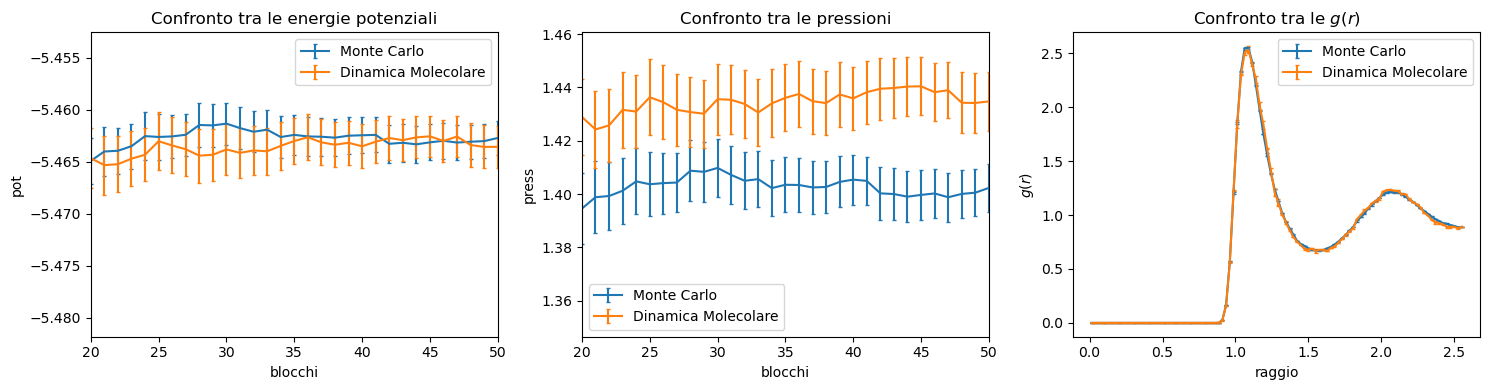

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import gridspec

# Caricamento dati
blocks, pot_MD, err_pot_MD = np.loadtxt("FILES_7.4/MD_potential_energy.dat", usecols=(0, 2, 3), unpack=True)
pot_MC, err_pot_MC = np.loadtxt("FILES_7.4/MC_potential_energy.dat", usecols=(2, 3), unpack=True)

press_MD, err_press_MD = np.loadtxt("FILES_7.4/MD_pressure.dat", usecols=(2, 3), unpack=True)
press_MC, err_press_MC = np.loadtxt("FILES_7.4/MC_pressure.dat", usecols=(2, 3), unpack=True)

raw_bins, raw_gofr_MD, raw_err_gofr_MD = np.loadtxt("FILES_7.4/MD_gofr.dat", usecols=(0, 2, 3), unpack=True)
raw_gofr_MC, raw_err_gofr_MC = np.loadtxt("FILES_7.4/MC_gofr.dat", usecols=(2, 3), unpack=True)

figure, axes= plt.subplots(1,3, figsize=(15,4))

axes[0].errorbar(blocks,pot_MC,yerr=err_pot_MC, capsize=1.5, label='Monte Carlo')
axes[0].errorbar(blocks,pot_MD,yerr=err_pot_MD, capsize=1.5, label='Dinamica Molecolare')
axes[0].set_title('Confronto tra le energie potenziali')
axes[0].set_xlabel('blocchi')
axes[0].set_xlim(20,50)
axes[0].set_ylabel('pot')
axes[0].legend()

axes[1].errorbar(blocks,press_MC,yerr=err_press_MC, capsize=1.5, label='Monte Carlo')
axes[1].errorbar(blocks,press_MD,yerr=err_press_MD, capsize=1.5, label='Dinamica Molecolare')
axes[1].set_title('Confronto tra le pressioni')
axes[1].set_ylabel('press')
axes[1].set_xlim(20,50)
axes[1].set_xlabel('blocchi')
axes[1].legend()

blocks=50
bins=100
start=bins*(1)
end = start+bins
bins = raw_bins[start:end]

gofr_MC = raw_gofr_MC[start:end]
err_gofr_MC = raw_err_gofr_MC[start:end]
axes[2].errorbar(bins, gofr_MC, yerr=err_gofr_MC, capsize=1.5, label='Monte Carlo')

gofr_MD = raw_gofr_MD[start:end]
err_gofr_MD = raw_err_gofr_MD[start:end]
axes[2].errorbar(bins, gofr_MD, yerr=err_gofr_MD, capsize=1.5, label='Dinamica Molecolare')
axes[2].set_title(r'Confronto tra le $g(r)$')
axes[2].set_ylabel(r'$g(r)$')
axes[2].set_xlabel('raggio')
axes[2].legend()

plt.tight_layout()
plt.show()

I grafici riportano il confronto tra le simulazioni Monte Carlo (MC) e Dinamica Molecolare (MD) per quanto riguarda l'energia potenziale per particella, la pressione e la funzione di distribuzione radiale $g(r)$. 

Nel primo e nell'ultimo caso si osserva una buona compatibilità tra i due metodi: le fluttuazioni dell'energia sono coerenti nei due casi, con valori medi molto simili all’interno delle barre d’errore. Anche il confronto tra le funzioni $g(r)$ mostra un’ottima sovrapposizione, confermando che entrambi i metodi di simulazione descrivono correttamente l'evoluzione del sistema.
   
Lo stesso non si può dire per la pressione, i cui valori medi risultano compatibili solo entro tre sigma. Come sottolineato anche dal docente, si può aspettare una coincidenza tra i valori ottenuti con metodi diversi solo nel limite termodinamico, in cui il numero di particelle $N\rightarrow \infty$ e il volume $V\rightarrow \infty$ mantenendo la densità $\rho$, condizione chiaramente non raggiunta nelle simulazioni effettuate.